## 1分足ヒストリカルデータの読み込み

[HistData.com](http://www.histdata.com) でダウンロードできるCSVデータは、EST（-0500）時間なので、日本時間に直すために、-14時間オフセットする。

In [76]:
import pandas
df_1mn = pandas.read_csv(
    "C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_USDJPY_M1_2017.csv",
    sep=';',
    names=('time','open','high','low','close', 'volume'),
    index_col='time', parse_dates=True
)
df_1mn.index += pandas.offsets.Hour(-14)
print(df_1mn.head(10))

                        open     high      low    close  volume
time                                                           
2017-01-01 12:00:00  116.858  116.870  116.858  116.870       0
2017-01-01 12:01:00  116.875  116.915  116.875  116.901       0
2017-01-01 12:02:00  116.901  116.901  116.901  116.901       0
2017-01-01 12:03:00  116.901  116.906  116.897  116.900       0
2017-01-01 12:04:00  116.900  116.903  116.900  116.903       0
2017-01-01 12:05:00  116.901  116.901  116.895  116.895       0
2017-01-01 12:06:00  116.893  116.897  116.893  116.897       0
2017-01-01 12:07:00  116.900  116.900  116.900  116.900       0
2017-01-01 12:10:00  116.894  116.900  116.894  116.900       0
2017-01-01 12:11:00  116.900  116.900  116.897  116.897       0


## 1分足→日足の変換

```df.resample('D').ohlc()``` とやりたくなるが、これだとうまくいかない。
[https://qiita.com/u1and0/items/8e7bcaaf3668ed2afee1](https://qiita.com/u1and0/items/8e7bcaaf3668ed2afee1)
また、```df.resample('D')```のところで、日曜日などの市場が空いていない日にはNaNが埋め込みされてしまうので、```df.dropna(inplace=True)```で削除する。
```df.resample('D')```で引数を'D'ではなく'H'にすれば時間足となる。

In [77]:
res = df_1mn.resample('D')
df_1dy = res.agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})
df_1dy.dropna(inplace=True)
print(df_1dy.head(10))

               open     high      low    close  volume
time                                                  
2017-01-01  116.858  117.498  116.858  117.458       0
2017-01-02  117.465  118.605  117.201  117.589       0
2017-01-03  117.590  118.184  117.052  117.403       0
2017-01-04  117.405  117.751  115.218  115.533       0
2017-01-05  115.530  117.179  115.069  117.166       0
2017-01-06  117.170  117.172  116.913  116.947       0
2017-01-08  117.002  117.531  115.958  116.276       0
2017-01-09  116.278  116.343  115.196  115.719       0
2017-01-10  115.718  116.870  114.244  114.989       0
2017-01-11  114.992  115.627  113.755  114.284       0


## ボリンジャーバンドの計算

window=20 で20日間のサンプリング幅となる。

In [78]:
bband_1dy = pandas.DataFrame()
bband_1dy['close'] = df_1dy['close']
move20 = df_1dy['close'].rolling(window=20)
bband_1dy['mean'] = move20.mean()
bband_1dy['std'] = move20.std()
print (bband_1dy[100:105])

              close       mean       std
time                                    
2017-04-27  111.395  109.91485  1.102554
2017-04-28  111.479  109.94315  1.136271
2017-04-30  111.846  109.96900  1.174690
2017-05-01  112.095  110.02085  1.246008
2017-05-02  112.368  110.09155  1.338431


## 複数の通貨ペアを一つのデータフレームに読み込む

ここでは、closeデータのみを取得する。

In [1]:
import pandas

def load_hist(f):
    import pandas
    df_1mn = pandas.read_csv(
        f,
        sep=';',
        names=('time','open','high','low','close', 'volume'),
        index_col='time', parse_dates=True
    )
    df_1mn.index += pandas.offsets.Hour(-14)
    res = df_1mn.resample('D')
    df_1dy = res.agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
    df_1dy.dropna(inplace=True)
    return df_1dy

def get_merged(**fs):
    import pandas
    dfs = pandas.DataFrame()
    for k, v in fs.items():
        df = load_hist(v)
        dfs[k] = df["close"]
    return dfs

dfs_1dy = get_merged(
    usd="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_USDJPY_M1_2017.csv",
    eur="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_EURJPY_M1_2017.csv",
    gbp="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_GBPJPY_M1_2017.csv",
    aud="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_AUDJPY_M1_2017.csv",
    nzd="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_NZDJPY_M1_2017.csv",
    chf="C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\DAT_ASCII_CHFJPY_M1_2017.csv"
)
print(dfs_1dy.head(5))

                usd      eur      gbp     aud     nzd      chf
time                                                          
2017-01-01  117.458  122.870  144.236  84.333  81.481  114.728
2017-01-02  117.589  122.466  143.903  84.975  81.421  114.462
2017-01-03  117.403  123.005  144.711  85.374  81.593  114.838
2017-01-04  115.533  122.467  143.571  84.840  81.179  114.348
2017-01-05  117.166  123.328  143.690  85.403  81.485  115.110


## 複数通貨データをEOF解析してみる

まずは、上で読み込んだ複数通貨の日変化データに欠損が入っているといけないので、それを消したうえで、Numpy Array に変換する。

In [80]:
import numpy as np
_dfs_1dy = dfs_1dy.dropna()
time_1dy = np.array(_dfs_1dy.index, dtype=np.datetime64)
xs = np.array(_dfs_1dy.columns)
nd_1dy = _dfs_1dy.values
print(time_1dy[:5])
print(xs)
print(nd_1dy[:5])

['2017-01-01T00:00:00.000000000' '2017-01-02T00:00:00.000000000'
 '2017-01-03T00:00:00.000000000' '2017-01-04T00:00:00.000000000'
 '2017-01-05T00:00:00.000000000']
['usd' 'eur' 'gbp' 'aud' 'nzd' 'chf']
[[117.458 122.87  144.236  84.333  81.481 114.728]
 [117.589 122.466 143.903  84.975  81.421 114.462]
 [117.403 123.005 144.711  85.374  81.593 114.838]
 [115.533 122.467 143.571  84.84   81.179 114.348]
 [117.166 123.328 143.69   85.403  81.485 115.11 ]]


また、EOF解析のために、各Columnを規格化しておく。

In [81]:
for j in range(nd_1dy.shape[1]):
    nd_1dy[:, j] /= nd_1dy[:, j].std()

EOF解析はscikitlernに同封されている関数を使う。

In [82]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nd_1dy)
eof = pca.fit_transform(nd_1dy)

寄与率を確認してみる。

Text(0,0.5,'explained variance ratio')

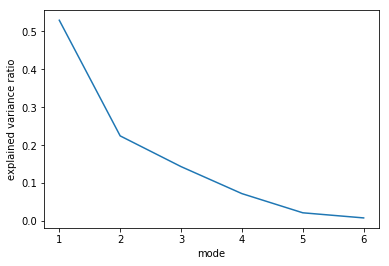

In [83]:
import matplotlib.pyplot as plt
plt.plot(
    np.arange(pca.explained_variance_ratio_.size) + 1,
    pca.explained_variance_ratio_
)
plt.xlabel("mode")
plt.ylabel("explained variance ratio")

第二モードまでで、全体の9割の変動を説明できそう。

そこで、第二モードまでのEOFとその時間関数を確認してみる。

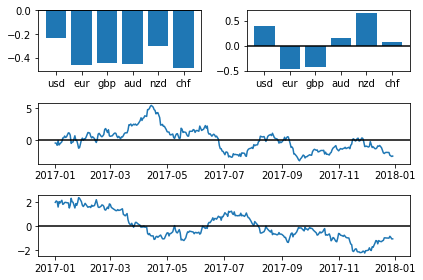

In [84]:
import matplotlib.pyplot as plt

# EOF mode1
plt.subplot(3, 2, 1)
plt.bar(xs, pca.components_[0])
plt.axhline(y=0, color='k')

# EOF mode2
plt.subplot(3, 2, 2)
plt.bar(xs, pca.components_[1])
plt.axhline(y=0, color='k')

# PC1
plt.subplot(3, 1, 2)
plt.plot(time_1dy, eof[:, 0])
plt.axhline(y=0, color='k')

# PC2
plt.subplot(3, 1, 3)
plt.plot(time_1dy, eof[:, 1])
plt.axhline(y=0, color='k')

plt.tight_layout()

取引高はUSDJPYが選んだ通過ペアの中で断トツだと思うので、第一モードはJPYが各通貨ペアに対して相対的に上昇（下降）したかを表していて、第二モードは、その相対変化からの変位を表しているということかな。
なので、AUDやNZDは円高（円安）時には、より強烈に円高（円安）が進行しやすくて、逆に、EURやGBPはやや円高（円安）の進行は抑えられたような値動きとなるということかな。

## 名目実効為替レートの読み込み

為替レートだと、結局のところ一番取引高の大きいペアに引っ張られてしまうようなので、名目実効為替レートをEOFを求めるということをやってみる。
ここでは、[https://www.bis.org/statistics/eer.htm?m=6%7C381%7C676](https://www.bis.org/statistics/eer.htm?m=6%7C381%7C676) でダウンロードした実効為替レートを読み込む。

まずは、ヘッダーのみ読み込んでみる。

In [48]:
import pandas

header = pandas.read_csv(
    "C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\WEBSTATS_EER_D_DATAFLOW_csv_row.csv",
    header=None, nrows=5
)
print(header)

               0                        1                       2   \
0       Frequency                  D:Daily                 D:Daily   
1            Type                N:Nominal               N:Nominal   
2          Basket   B:Broad (61 economies)  B:Broad (61 economies)   
3  Reference area  AE:United Arab Emirates            AR:Argentina   
4     Time Period                 D:N:B:AE                D:N:B:AR   

                       3                       4                       5   \
0                 D:Daily                 D:Daily                 D:Daily   
1               N:Nominal               N:Nominal               N:Nominal   
2  B:Broad (61 economies)  B:Broad (61 economies)  B:Broad (61 economies)   
3              AT:Austria            AU:Australia              BE:Belgium   
4                D:N:B:AT                D:N:B:AU                D:N:B:BE   

                       6                       7                       8   \
0                 D:Daily              

どうやら以下のような略字の組み合わせが5行目に書かれているみたい。

Interval: D (Daily)

Type: N (Nominal)

Basket: B (Broad), N (Narrow)

Area: 地域名（United States ならUSのような感じ）

ここで、BasketはBroadだと実質、Narrowだと名目ということになる。

ヘッダー構造が分かったので、5行目をヘッダーとして読み込む。

In [2]:
import pandas

erate = pandas.read_csv(
    "C:\\Users\\katsu\\Documents\\git_work\\learnfx\\data\\WEBSTATS_EER_D_DATAFLOW_csv_row.csv",
    header=4, index_col='Time Period', parse_dates=True
)
print(erate.head(1))

             D:N:B:AE  D:N:B:AR  D:N:B:AT  D:N:B:AU  D:N:B:BE  D:N:B:BG  \
Time Period                                                               
1983-10-03        NaN       NaN       NaN       NaN       NaN       NaN   

             D:N:B:BR  D:N:B:CA  D:N:B:CH  D:N:B:CL    ...     D:N:N:KR  \
Time Period                                            ...                
1983-10-03        NaN       NaN       NaN       NaN    ...       229.09   

             D:N:N:NL  D:N:N:NO  D:N:N:NZ  D:N:N:PT  D:N:N:SE  D:N:N:SG  \
Time Period                                                               
1983-10-03      84.59    115.73    124.38    175.24    133.23     90.86   

             D:N:N:TW  D:N:N:US  D:N:N:XM  
Time Period                                
1983-10-03     119.19    152.67     86.28  

[1 rows x 87 columns]


あとは、必要な期間と国（通貨）のみ取り出す。
国名は略字となっていて、アメリカドル（US）、円（JP）、オーストラリアドル（AU）、ニュージーランドドル（NZ）、イギリスポンド（GB）、ユーロ（XM）、スイスフラン（CH）となっている。
そのままだとちょっと分かりにくい名前なので、名前も付け替えておく。

In [3]:
_erate = erate.loc[
    "2017-01-01": "2017-12-31", 
    ["D:N:N:US", "D:N:N:JP", "D:N:N:AU", "D:N:N:NZ", "D:N:N:GB", "D:N:N:XM", "D:N:N:CH"]
]
erate_ = pandas.DataFrame()
erate_["usd"] = _erate["D:N:N:US"]
erate_["eur"] = _erate["D:N:N:XM"]
erate_["jpy"] = _erate["D:N:N:JP"]
erate_["gbp"] = _erate["D:N:N:GB"]
erate_["aud"] = _erate["D:N:N:AU"]
erate_["nzd"] = _erate["D:N:N:NZ"]
erate_["chf"] = _erate["D:N:N:CH"]
print(erate_.head(5))

                usd    eur    jpy    gbp    aud     nzd     chf
Time Period                                                    
2017-01-01      NaN    NaN    NaN    NaN    NaN     NaN     NaN
2017-01-02   124.09  89.46  82.51  95.65  90.11  115.21  123.62
2017-01-03   124.58  89.00  82.20  96.11  90.92  115.14  123.45
2017-01-04   123.79  89.15  82.35  95.72  91.10  115.11  123.50
2017-01-05   123.16  89.39  82.67  95.26  91.06  114.80  123.68


## 名目実効為替レートのEOF解析

普通の為替レートでEOF解析したときと同じ方針で、EOF解析してみる。
まずは、欠損の除去とNumpy Array 化を行う。

In [4]:
import numpy as np

# _dfs_1dy = erate_.diff().dropna()
_dfs_1dy = erate_.dropna()
time_1dy = np.array(_dfs_1dy.index, dtype=np.datetime64)
xs = np.array(_dfs_1dy.columns)
nd_1dy = _dfs_1dy.values
print(time_1dy[:5])
print(xs)
print(nd_1dy[:5])

['2017-01-02T00:00:00.000000000' '2017-01-03T00:00:00.000000000'
 '2017-01-04T00:00:00.000000000' '2017-01-05T00:00:00.000000000'
 '2017-01-06T00:00:00.000000000']
['usd' 'eur' 'jpy' 'gbp' 'aud' 'nzd' 'chf']
[[124.09  89.46  82.51  95.65  90.11 115.21 123.62]
 [124.58  89.    82.2   96.11  90.92 115.14 123.45]
 [123.79  89.15  82.35  95.72  91.1  115.11 123.5 ]
 [123.16  89.39  82.67  95.26  91.06 114.8  123.68]
 [122.63  89.86  82.93  95.25  91.29 115.39 123.72]]


各Columnを規格化する。

In [5]:
for j in range(nd_1dy.shape[1]):
    nd_1dy[:, j] /= nd_1dy[:, j].std()

EOF解析を実行する。

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nd_1dy)
eof = pca.fit_transform(nd_1dy)

寄与率を確認してみる。

In [7]:
import matplotlib.pyplot as plt
plt.plot(
    np.arange(pca.explained_variance_ratio_.size) + 1,
    pca.explained_variance_ratio_
)
plt.xlabel("mode")
plt.ylabel("explained variance ratio")

Text(0,0.5,'explained variance ratio')

今度は、第3モードまでみれば良さそう。

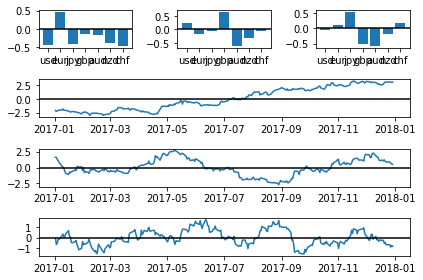

In [7]:
import matplotlib.pyplot as plt

# EOF mode1
plt.subplot(4, 3, 1)
plt.bar(xs, pca.components_[0])
plt.axhline(y=0, color='k')

# EOF mode2
plt.subplot(4, 3, 2)
plt.bar(xs, pca.components_[1])
plt.axhline(y=0, color='k')

# EOF mode3
plt.subplot(4, 3, 3)
plt.bar(xs, pca.components_[2])
plt.axhline(y=0, color='k')

# PC1
plt.subplot(4, 1, 2)
plt.plot(time_1dy, eof[:, 0])
plt.axhline(y=0, color='k')

# PC2
plt.subplot(4, 1, 3)
plt.plot(time_1dy, eof[:, 1])
plt.axhline(y=0, color='k')

# PC3
plt.subplot(4, 1, 4)
plt.plot(time_1dy, eof[:, 2])
plt.axhline(y=0, color='k')

plt.tight_layout()

なるほど。第一成分はほぼ単調増加で、第二成分は波数２、第3成分は波数4みたいに見える。

次は、位相空間に投影してみよう。

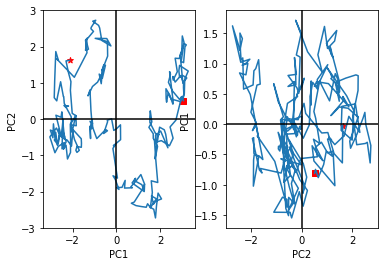

In [8]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(eof[:, 0], eof[:, 1])
plt.scatter(eof[0, 0], eof[0, 1], marker="*", color='r')
plt.scatter(eof[-1, 0], eof[-1, 1], marker="s", color='r')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.subplot(1, 2, 2)
plt.plot(eof[:, 1], eof[:, 2])
plt.scatter(eof[0, 1], eof[0, 2], marker="*", color='r')
plt.scatter(eof[-1, 1], eof[-1, 2], marker="s", color='r')
plt.xlabel("PC2")
plt.ylabel("PC1")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

ちょっと汚いので、20日移動平均を掛けてから、同じように投影してみる。

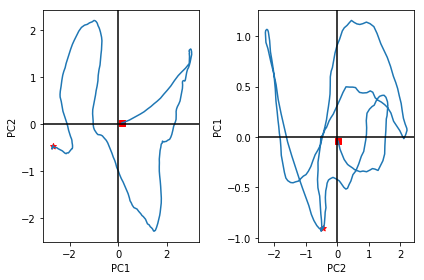

In [9]:
import numpy as np
maeof = np.empty_like(eof)
w = np.ones([40], dtype=float)
w[20:] = 0.0
w /= 20.
for j in range(eof.shape[1]):
    maeof[:, j] = np.convolve(
        eof[:, j], w, mode='same'
    )
    maeof[:20, j] = np.nan
    
plt.subplot(1, 2, 1)
plt.plot(maeof[:, 0], maeof[:, 1])
plt.scatter(maeof[20, 0], maeof[20, 1], marker="*", color='r')
plt.scatter(maeof[-1, 0], maeof[-1, 1], marker="s", color='r')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.subplot(1, 2, 2)
plt.plot(maeof[:, 1], maeof[:, 2])
plt.scatter(maeof[20, 1], maeof[20, 2], marker="*", color='r')
plt.scatter(maeof[-1, 1], maeof[-1, 2], marker="s", color='r')
plt.xlabel("PC2")
plt.ylabel("PC1")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.tight_layout()

各象限にいるときに、その時に合わせたポジション取りをすれば、うまくトレードできるんじゃないか？

ということで、逆張り的な発想で下記のように各象限内で毎日ポジションを積み立てて、象限が変わったら決済するということを繰り返すバックテストを行ってみる。

|         象限 | USD | EUR | AUD |
| ------------ | --- | --- | --- |
| PC1>0, PC2>0 | 買  | 売  |     |
| PC1>0, PC2<0 | 買  | 売  | 買  |
| PC1<0, PC2>0 | 売  | 買  | 売  |
| PC1<0, PC2<0 | 売  | 買  |     |

初期資産は日本円1万円で、一日あたりの積み立て額は100円とする。
最後は強制的に決済して終了とする。

In [75]:
import pandas

init = 10000.
acc = 100.

dmaeof = pandas.DataFrame(
    maeof, index=time_1dy
)
assets = pandas.DataFrame(index=time_1dy)
assets["tot"] = 0.
assets["tot"][0] = init
assets["est"] = 0.
assets["est"][0] = init
jpy = 0.
usd = 0.
eur = 0.
aud = 0.

def estimate_value(t):
    v = jpy
    v += usd * dfs_1dy["usd"][t]
    v += eur * dfs_1dy["eur"][t]
    v += aud * dfs_1dy["aud"][t]
    return v

for ta, tb in zip(assets.index[0:], assets.index[1:]):
    if tb not in dmaeof.index:
        continue
        
    assets["tot"][tb] = assets["tot"][ta]
    assets["est"][tb] = assets["est"][ta]
    
    if dfs_1dy.loc[tb].isnull().any() or dmaeof.loc[tb].isnull().any():
        continue
        
    if dmaeof[0][tb] * dmaeof[0][ta] < 0. or dmaeof[1][tb] * dmaeof[1][ta] < 0.:
        assets["tot"][tb] += estimate_value(tb)
        jpy = 0.
        usd = 0.
        eur = 0.
        aud = 0.
        
    if dmaeof[0][tb] > 0. and dmaeof[1][tb] > 0.:
        usd += acc / dfs_1dy["usd"][tb]
        eur -= acc / dfs_1dy["eur"][tb]
    
    if dmaeof[0][tb] > 0. and dmaeof[1][tb] < 0.:
        jpy -= acc
        usd += acc / dfs_1dy["usd"][tb]
        eur -= acc / dfs_1dy["eur"][tb]
        aud += acc / dfs_1dy["aud"][tb]
        
    if dmaeof[0][tb] < 0. and dmaeof[1][tb] > 0.:
        jpy += acc
        usd -= acc / dfs_1dy["usd"][tb]
        eur += acc / dfs_1dy["eur"][tb]
        aud -= acc / dfs_1dy["aud"][tb]
        
    if dmaeof[0][tb] < 0. and dmaeof[1][tb] < 0.:
        usd -= acc / dfs_1dy["usd"][tb]
        eur += acc / dfs_1dy["eur"][tb]
        
    assets["est"][tb] = assets["tot"][tb] + estimate_value(tb)
        
assets["tot"][tb] += estimate_value(tb)
jpy = 0.
usd = 0.
eur = 0.
aud = 0.
assets["est"][tb] = assets["tot"][tb] + estimate_value(tb)

last: 10234 yen


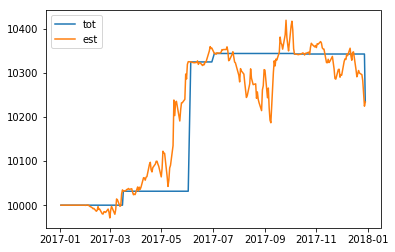

In [76]:
import matplotlib.pyplot as plt

plt.plot(assets.index, assets["tot"], label="tot")
plt.plot(assets.index, assets["est"], label="est")
plt.legend()

print("last: %d yen" % assets["tot"][-1])

2.34% (234円）増えた。ただし、スプレッドとスワップを考慮していないことに注意です。